In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

Load all the training and test data

In [28]:
data = pd.read_csv("sign_mnist_train.csv")
data_test = pd.read_csv("sign_mnist_test.csv")

y = data.label
X = np.ascontiguousarray(data.iloc[:,1:].values)

y_test = data_test.label
X_test = np.ascontiguousarray(data_test.iloc[:,1:].values)

data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Calculate average image for each class

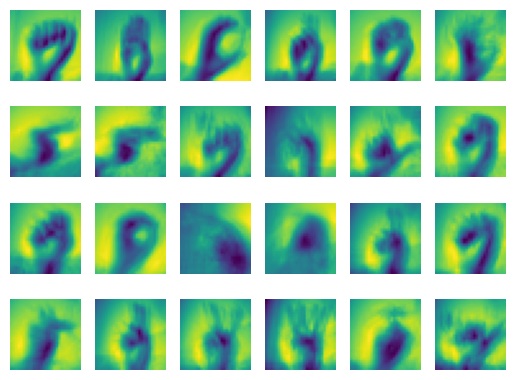

In [3]:
classes = sorted(set(data.label))

fig, axis = plt.subplots(4, 6)

for idx, c in enumerate(classes):
    class_rows = data[data.label == c].iloc[:,1:]

    # apply contrast stretching to images before mean
    mins = class_rows.min(axis="columns")
    maxs = class_rows.max(axis="columns")
    class_rows = class_rows.sub(mins, axis=0 ).div(maxs.sub(mins, axis=0), axis=0) * 255

    img = class_rows.mean().round().to_numpy().reshape((28,28))

    i = idx // 6
    j = idx % 6

    axis[i,j].imshow(img)
    axis[i,j].axis('off')


# Trying various classifiers

### Logistic Regression

In [49]:
logitN = LogisticRegression(max_iter=3000, C=0.5)
logitN.fit(X,y)
print(logitN.score(X, y))

1.0


In [50]:
print(logitN.score(X_test, y_test))

0.677356385945343


### SGD Classifier

In [16]:
sgd = SGDClassifier("hinge", max_iter=3000)  # hinge -> linear SVM, log_loss -> logistic regr
sgd.fit(X,y)
print(sgd.score(X, y))
print(sgd.score(X_test, y_test))

0.9976324895283191
0.6436140546569994


In [17]:
sgd_log = SGDClassifier("log_loss", max_iter=3000)  # hinge -> linear SVM, log_loss -> logistic regr
sgd_log.fit(X,y)
print(sgd_log.score(X, y))
print(sgd_log.score(X_test, y_test))

0.9982516845747587
0.6466815393195762


### SVM

Trying various kernels

In [19]:
kernels = ["linear", "poly", "rbf"]   #, "sigmoid"] sigmoid suuuuuucks, rbf does best
for k in kernels:
    svm = SVC(kernel=k)
    svm.fit(X, y)
    print(k, ":", svm.score(X, y))
    print(k, ":", svm.score(X_test, y_test))

linear : 1.0
linear : 0.7816508644729504
poly : 1.0
poly : 0.782069157836029
rbf : 1.0
rbf : 0.8418851087562744
sigmoid : 0.047131670005463484
sigmoid : 0.020078081427774678


Trying various values of C for `rbf` kernel

In [20]:
for c in [0.01, 0.1, 0.2, 0.5, 1, 2]:
    svm = SVC(kernel="rbf", C=c)
    svm.fit(X, y)
    print(f"C = {c}, train:", svm.score(X, y))
    print(f"C = {c}, test :", svm.score(X_test, y_test))

C = 0.01, train: 0.44724093971954104
C = 0.01, test : 0.32124930284439485
C = 0.1, train: 0.9468220724822437
C = 0.1, test : 0.7732849972113776
C = 0.2, train: 0.9896922236386815
C = 0.2, test : 0.8197155605131066
C = 0.5, train: 0.9997814605718448
C = 0.5, test : 0.8375627440044618
C = 1, train: 1.0
C = 1, test : 0.8418851087562744
C = 2, train: 1.0
C = 2, test : 0.839654210819855


Trying various polynomial degrees for `poly` kernel

In [29]:
for deg in [5, 6, 7, 8, 9, 10]:
    svm = SVC(kernel="poly", C=1, degree=deg)
    svm.fit(X, y)
    print(f"Deg = {deg}, train:", svm.score(X, y))
    print(f"Deg = {deg}, test :", svm.score(X_test, y_test))

Deg = 5, train: 1.0
Deg = 5, test : 0.7663134411600669
Deg = 6, train: 1.0
Deg = 6, test : 0.7518126045733408
Deg = 7, train: 1.0
Deg = 7, test : 0.7293641940881205
Deg = 8, train: 1.0
Deg = 8, test : 0.6957612939208031
Deg = 9, train: 1.0
Deg = 9, test : 0.6691299498047965
Deg = 10, train: 1.0
Deg = 10, test : 0.643335192414947


Performing a grid search with a 5-fold cross-validation strategy to find parameters for `rbf` kernel
(VERY VERY time-consuming!)

In [47]:
from sklearn.model_selection import GridSearchCV

C_range = [1.15, 1.2, 1.25]  #[0.8, 0.9, 1, 1.1, 1.2, 1.3] #np.logspace(0.5, 2, 6)
gamma_range = [5.0e-07, 5.5e-07, 6e-07] #np.logspace(-8, -6, 8) # [5.362746102833047e-07]
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=-3, verbose=2)  # defaults to 5-fold CV, n_jobs=-3 -> use all but 2 CPUs
grid.fit(X, y)

print(f"Best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}")
# Best parameters are {'C': 1.2, 'gamma': 5.179474679231213e-07} with a score of 1.00
# Best parameters are {'C': 1.15, 'gamma': 5e-07} with a score of 1.00

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters are {'C': 1.15, 'gamma': 5e-07} with a score of 1.00


In [48]:
grid.score(X_test, y_test)

0.8397936419408812

### Nearest Neighbours Classification

Trying various values for `n_neighbors`

In [40]:
from sklearn.neighbors import KNeighborsClassifier

for n in [1, 3, 5]: # range(1, 16)
    nn = KNeighborsClassifier(n_neighbors=n)
    nn.fit(X, y)
    print(f"n_neighbors = {n}, train:", nn.score(X, y))
    print(f"n_neighbors = {n}, test :", nn.score(X_test, y_test))

n_neighbors = 1, train: 1.0
n_neighbors = 1, test : 0.8103736754043502
n_neighbors = 3, train: 0.9998543070478966
n_neighbors = 3, test : 0.8039598438371445
n_neighbors = 5, train: 0.9992715352394828
n_neighbors = 5, test : 0.8059118795315114


Doing a grid search with 5-fold CV to find best combination of `n_neighbors` and `weights`.

Unsure if it works quite right as the test scores are `nan`, but it does select `n_neighbors=1` as the best one, as seen on the for loop right before this.

In [38]:
neighbors_range = list(range(1, 10))
weights_range = ["uniform", "distance"]
param_grid = dict(n_neighbors=neighbors_range, weights=weights_range)
grid_nn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=-3)  # defaults to 5-fold CV, n_jobs=-3 -> use all but 2 CPUs
grid_nn.fit(X, y)

print(f"Best parameters are {grid_nn.best_params_} with a score of {grid_nn.best_score_:.2f}")
print("test score:", grid_nn.score(X_test, y_test))

C:\Users\diomo\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters are {'n_neighbors': 1, 'weights': 'uniform'} with a score of nan
test score: 0.8103736754043502


## Summary

The best two best classifiers found were the SVM classifier with the `rbf` kernel and the K-Nearest Neighbors classifier.

The default SVC settings used by sklearn did best with the test data, with an accuracy of around 84.2%, while a more exhaustive search with a grid search using a 5-fold cross-validation strategy achieved an accuracy of around 83.9%, with parameters `C=1.15` and `gamma=5e-07`.

The KNeighborsClassifier was tested with varying amounts of neighbors and different weight parameters, and the best classifier found used 1 neighbor and `uniform` weights, with an accuracy of 81%, and the second best used 5 neighbors and `uniform` weights, with an accuracy of 80.6%.